<center> <h1> Topological Data Analysis</h1> <center>
<center> <h2> Exploratory Analysis using Artificially made data</h2> <center>

In this notebook the goal is to reproduce the result in the paper [A Topological Data Analysis of Navigation Paths
within Digital Libraries](https://ceur-ws.org/Vol-3558/paper935.pdf) using generated data. The goal is to see which kind of patterns we will have using the discussed method in the paper while having acess to all the information about the behaviour of users.

The notebook will be separated in three main parts:

<ol>
 <li> Data Generation </li>
 <li> Paper Pipeline </li>
 <li> Discussion & Optimization </li>
</ol>

While in real life we do not have access to the real distributions, it is always good to see how those methods acts to see their advantages and their weaknesses. I will try to expalain as much as possible so I hope it will be clear for you.

# 1. Data

The first part is data generation. The real world data is messy and hard to understand, I would like to create data that look as much as possible as the real life, the problem is that the way I will create a data include biases related to my owne perception of the world. To make things simple, I will consider a library that contains diffrent books for each topic, while in real life one book could treat diffrent types of topics I will consider one topic for each book. I will also include some features like titles and date of publication for each book. (**Note:** The data was generated by **ChatGPT**)

In [1]:
from tda_utils import *

In [2]:
import json

#Load the small dataset
with open("toy_dataset.json", 'r') as f:

    data = json.load(f)

print("The contained themes:", *data.keys())

The contained themes: Droit Musique Histoire Science Technologie Art Cuisine Sport Mode Environnement Éducation Santé Voyages Philosophie Politique


In [3]:
for topic in data.keys():

    print("Number of themes in", topic, len(data[topic]))

Number of themes in Droit 6
Number of themes in Musique 9
Number of themes in Histoire 10
Number of themes in Science 10
Number of themes in Technologie 8
Number of themes in Art 8
Number of themes in Cuisine 8
Number of themes in Sport 7
Number of themes in Mode 6
Number of themes in Environnement 10
Number of themes in Éducation 15
Number of themes in Santé 10
Number of themes in Voyages 10
Number of themes in Philosophie 10
Number of themes in Politique 10


This is a small example of what a theme could contain as books

In [4]:
data["Droit"]

[{'title': 'Évolution des lois sur la propriété intellectuelle',
  'year': '2022'},
 {'title': "Débats actuels sur la liberté d'expression", 'year': '2021'},
 {'title': "Réformes juridiques pour la protection de l'environnement",
  'year': '2023'},
 {'title': 'Justice sociale et équité : Un examen approfondi', 'year': '2020'},
 {'title': 'Lutte contre la cybercriminalité : Enjeux contemporains',
  'year': '2022'},
 {'title': "Droits de l'homme dans le contexte mondial", 'year': '2021'}]

Now that we have our small ***"digital library"*** we can start building our users behaviours. Which lead us to the question what is a behaviour in a digital library. While this question is hard to answer and can have diffrent answers, we will consider a behaviour as a recurent pattern that appear in a a navigation session. To be more precise I will modelize a behaviour as a result of one specific transition matrix to navigate from a document to another also from a topic or theme to another.

To be more precise, let $B$ a finite set of transition matrices. $B$ = {$B_1$,..., $B_n$}. This set is give information to navigate from one topic to another, and to navigate from one document to another, I decided to use a list with probabilities for each document in a specific theme, we use $P_{theme}$ = [$P_1$, ...,$P_m$], where $P_i$ is the probability to pic the document $i$ when the user decided the theme.

Next the behaviour will be the process of selecting documents using those defined probabilities, We select randomlly a theme using the transition matrix $P(T=theme_i)$ then we pick randomlly a document in the collection using $P(D=document_i|T=theme_i)$.

Let's have an example of one transition matrix of a specific behaviour $B_i$, the method bellow generate a transition matrix using a variability parameter that control the probability of staying in the same theme, a higher variability lead to commun probabilies everywhere in the matrix.

<Axes: >

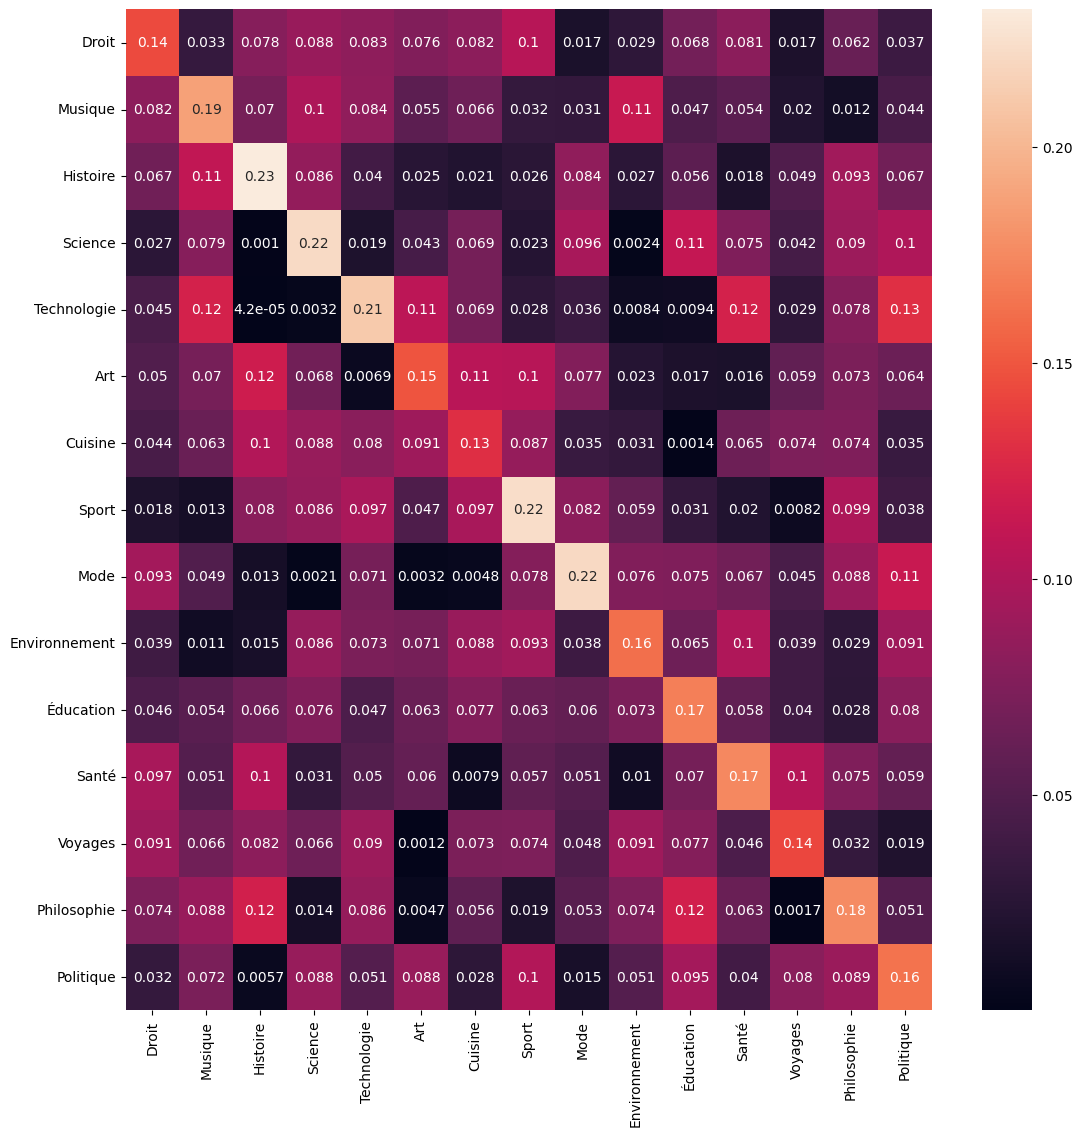

In [5]:
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

#Change the variability parameters to get diffrent results try for example: 0.1 and 2 to see the diffrence
transition_matrix = generate_transition_matrix(data.keys(), variability=1)

tmf = pd.DataFrame(transition_matrix, index=data.keys(), columns=data.keys())

plt.figure(figsize=(13, 13))

sns.heatmap(tmf, annot=True)

The generated transition matrix is not perfect and there is also some little details to consider, first I have only one parameter that control how much probability I give to the elements on the diagonal (the probability to stay in the same topic) which include some bias, where some users can navigate with a higher probability from one topic to another. The second thing is that the way I generated the matrix I have only lines that have a sum of probabilities is equal to one, the columns don't have this proprety but it is not important because I will use only the lines.

Now for the probabilities of documents we should also have a sum equal to 1, but we can have diffrent types of distributions. In my case I decided to use the Dirichlet distribution to generate these lists, this distribution can give either a list almost generated by uniform distribution or a list with high variance between the probabilities. Bellow an example of two lists with diffrent parameters.

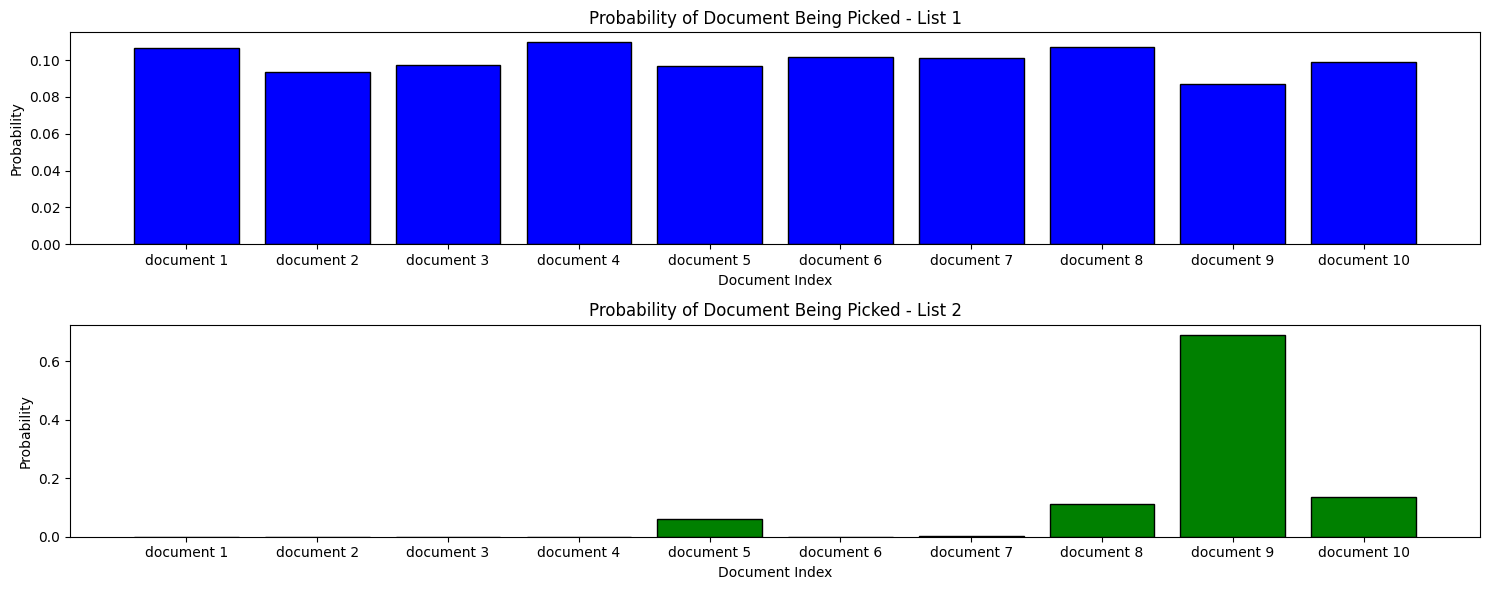

In [6]:
doc_pro1 = np.random.dirichlet(np.ones(10)*100, size=1)

doc_pro2 = np.random.dirichlet(np.ones(10)/10, size=1)

doc_indices = ["document "+str(i) for i in range(1, doc_pro1.shape[1]+1)]

# Create bar plots using Matplotlib's pyplot
plt.figure(figsize=(15, 6))

plt.subplot(2, 1, 1)
plt.bar(doc_indices, doc_pro1[0], color='blue', edgecolor='black')
plt.title('Probability of Document Being Picked - List 1')
plt.xlabel('Document Index')
plt.ylabel('Probability')

plt.subplot(2, 1, 2)
plt.bar(doc_indices, doc_pro2[0], color='green', edgecolor='black')
plt.title('Probability of Document Being Picked - List 2')
plt.xlabel('Document Index')
plt.ylabel('Probability')

plt.tight_layout()
plt.show()

We can now generate our data, using the two parameters the variability and the $\alpha$ parameter of the dirichlet distribution we have a large spectrum of possible behaviours although the model that generate the data does not reflect the reality missing a lot of details, I would like to add a last parameter wich is the session action length, we can try to generate diffrent type fo actions length: long sessions, medium sessions and small sessions. It is hard to define what is medium, long and small, in my case this is how I define them:

<ul> 
    <li> Small session: a sequence of 1 or 2</li>
    <li> Medium session: a sequence of size between 2 and 5 </li>
    <li> Long session: a sequence of length 5 or higher (In my case I will limit to 20) </li>
</ul>

For this demo I decided to describe 7 types of behaviours:

<ul>
    <li> Reaserch Behaviour (Type 1): Transition matrix with a small variability, high alpha and small session size.</li>
    <li> Reaserch Behaviour (Type 2): Transition matrix with a small variability, medium alpha and small session size.</li>
    <li> Reaserch Behaviour (Type 3): Transition matrix with a medium variability, small alpha and  medium size</li>
    <li> Explore Behaviour (Type 1): Transition matrix with a high variability, medium alpha and long session size</li>
    <li> Explore Behaviour (Type 2): Transition matrix with a high variability, high alpha and long session size</li>
    <li> Explore Behaviour (Type 3): Transition matrix with a medium variability, high alpha and medium session size</li>
    <li> Medium Behaviour: Transition matrix with a medium variability, medium alpha and  medium size</li>
</ul>

I will not sample the same number of elements in each category, for each class the number of samples will be between 500  and 700 samples.

In [7]:
SMALL_VARIABILITY = 0.2 

MEDIUM_VARIABILITY = 1

HIGH_VARIABILITY = 10

In [8]:
SMALL_ALPHA = 0.1

MEDIUM_ALPHA = 1

HIGH_ALPHA = 100

In [9]:
BEHAVIOURS_SPECIFY = [
    (SMALL_VARIABILITY, HIGH_ALPHA, np.random.randint(3_000, 7_001), "small"),
    (SMALL_VARIABILITY, MEDIUM_ALPHA, np.random.randint(3_000, 7_001), "small"),
    (MEDIUM_VARIABILITY, SMALL_ALPHA, np.random.randint(3_000, 7_001), "medium"),
    (HIGH_VARIABILITY, MEDIUM_ALPHA, np.random.randint(3_000, 7_001), "long"),
    (HIGH_VARIABILITY, HIGH_VARIABILITY, np.random.randint(3_000, 7_001), "long"),
    (MEDIUM_VARIABILITY, HIGH_ALPHA, np.random.randint(3_000, 7_001), "medium"),
    (MEDIUM_VARIABILITY, MEDIUM_ALPHA, np.random.randint(3_000, 7_001), "medium"),
]

In [10]:
sessions = generate_dataset(BEHAVIOURS_SPECIFY, data)

  0%|          | 0/7 [00:00<?, ?it/s]

# 2. Topological Data analysis (TDA)

## 2.1 Word2Vec Embedding

The goal in this part is to create a vectorized representation of the themes to use them for the toplogical data analysis. The method that is proposed in the paper was the Skip-gramms, but we will also try the CBOW method in order to see if there is interesting results.

But before starting, we need to construct our corpus, the corpus will contain as sentences a list of themes [$theme_1$, ... ,$theme_n$] with $n$ the session size which may differ from one session to another.

In [11]:
def extract_corpus(sessions):

    result = []

    for session in sessions:

        themes = []

        for docuement in session:

            themes.append(docuement[0])

        result.append(themes)

    return result


In [12]:
corpus = extract_corpus(sessions=sessions)

In [13]:
import gensim
from gensim.models import Word2Vec
from gensim.test.utils import common_texts

In [14]:
# Train Word2Vec model
model = Word2Vec(corpus, vector_size=50, window=5, min_count=1, workers=4)

In the paper after using the Word2Vec to get the representation of the themes they reduce the dimensionality of the data using the t-sne algorithm to get vector of 2 dimensions

In [15]:
vocab = list(model.wv.key_to_index)
X = model.wv[vocab]

In [16]:
from sklearn.manifold import TSNE

# Perform dimensionality reduction using t-SNE
tsne = TSNE(n_components=2, random_state=42, perplexity=10)
X_tsne = tsne.fit_transform(X)

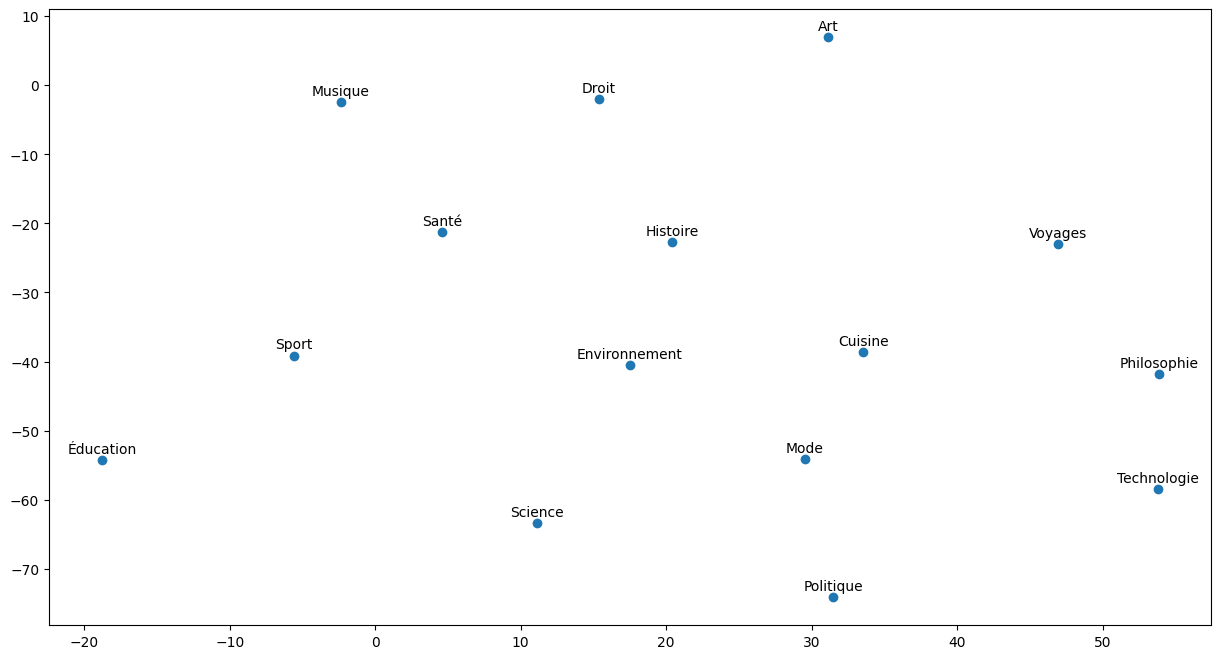

In [17]:
plt.figure(figsize=(15, 8))

plt.scatter(X_tsne[:, 0], X_tsne[:, 1])

for i, label in enumerate(vocab):
    
    plt.annotate(label, (X_tsne[i, 0], X_tsne[i, 1]), textcoords="offset points", xytext=(0, 5), ha='center')

plt.show()

## 2.2 TDA

Before we start the TDA, we should transform each session from a sequence of words to a sequence of vectors.

In [18]:
#Create a dictionary to map each theme with it's representation
themes_vectors = {theme: X_tsne[i] for i, theme in enumerate(vocab)}

In [19]:
def themes_to_vectors(theme_names_list, theme_representation_dict):
    """
    Convert a list of lists of theme names into a list of lists of vectors using a theme representation dictionary.

    Parameters:
        theme_names_list (list): List of lists where each inner list contains theme names.
        theme_representation_dict (dict): Dictionary mapping theme names to their vector representations.

    Returns:
        list: List of lists where each inner list contains vectors corresponding to the theme names.
    """
    vectors_list = []

    for inner_list in theme_names_list:
        vectorized_inner_list = np.array([theme_representation_dict[theme] for theme in inner_list])
        vectors_list.append(vectorized_inner_list)

    return vectors_list

In [20]:
themes_vectors

{'Technologie': array([ 53.780994, -58.519604], dtype=float32),
 'Philosophie': array([ 53.85378 , -41.782955], dtype=float32),
 'Éducation': array([-18.795767, -54.232277], dtype=float32),
 'Environnement': array([ 17.483793, -40.519344], dtype=float32),
 'Sport': array([ -5.5885377, -39.149788 ], dtype=float32),
 'Santé': array([  4.577343, -21.252857], dtype=float32),
 'Cuisine': array([ 33.56454 , -38.578392], dtype=float32),
 'Voyages': array([ 46.929752, -23.012953], dtype=float32),
 'Politique': array([ 31.465883, -74.12282 ], dtype=float32),
 'Art': array([31.11294 ,  6.946904], dtype=float32),
 'Science': array([ 11.119588, -63.347904], dtype=float32),
 'Mode': array([ 29.521088, -54.125607], dtype=float32),
 'Musique': array([-2.3802297, -2.4112785], dtype=float32),
 'Droit': array([15.375767 , -1.9605694], dtype=float32),
 'Histoire': array([ 20.388367, -22.716284], dtype=float32)}

In [21]:
points_clouds = themes_to_vectors(corpus, themes_vectors)

In [22]:
from gtda.homology import VietorisRipsPersistence

homology_dimensions = [0, 1, 2]

# Collapse edges to speed up H2 persistence calculation!
persistence = VietorisRipsPersistence(
    metric="euclidean",
    homology_dimensions=homology_dimensions,
    n_jobs=6,
    collapse_edges=True,
)

diagrams= persistence.fit_transform(points_clouds)

In [23]:
from gtda.diagrams import PersistenceEntropy

persistence_entropy = PersistenceEntropy()

# calculate topological feature matrix
patterns = persistence_entropy.fit_transform(diagrams)

In [24]:
patterns.shape

(39589, 3)

# 3. Create clusters

In this part we will create clusters using the representations we got from the last part

In [25]:
from sklearn.cluster import MiniBatchKMeans
from sklearn.metrics import silhouette_samples, silhouette_score
from tqdm.auto import tqdm

In [26]:
#use the Mini Batch Kmeans and find the best cluster based on the silhouette score

def mini_batch_clustering(data, k_limit=10, batch_size=100, random_state=None):

    best_k = 2  # Minimum value for k
    inertia_scores = []
    silhouette_scores = []

    for k in tqdm(range(2, k_limit + 1)):
        # Mini Batch K-Means clustering
        kmeans = MiniBatchKMeans(n_clusters=k, batch_size=batch_size, random_state=random_state)
        labels = kmeans.fit_predict(data)

        # Inertia (within-cluster sum of squared distances)
        inertia_scores.append(kmeans.inertia_)

        # Silhouette Score
        silhouette_avg = silhouette_score(data, labels)
        silhouette_scores.append(silhouette_avg)

        # Update best k based on silhouette score
        if silhouette_avg > silhouette_scores[best_k - 2]:  # -2 because range starts from 2
            best_k = k

    return best_k, inertia_scores, silhouette_scores

In [27]:
best_k, inertia_scores, silhouette_scores = mini_batch_clustering(patterns, batch_size=4_000)

print("Best k:", best_k)

  0%|          | 0/9 [00:00<?, ?it/s]

Best k: 9


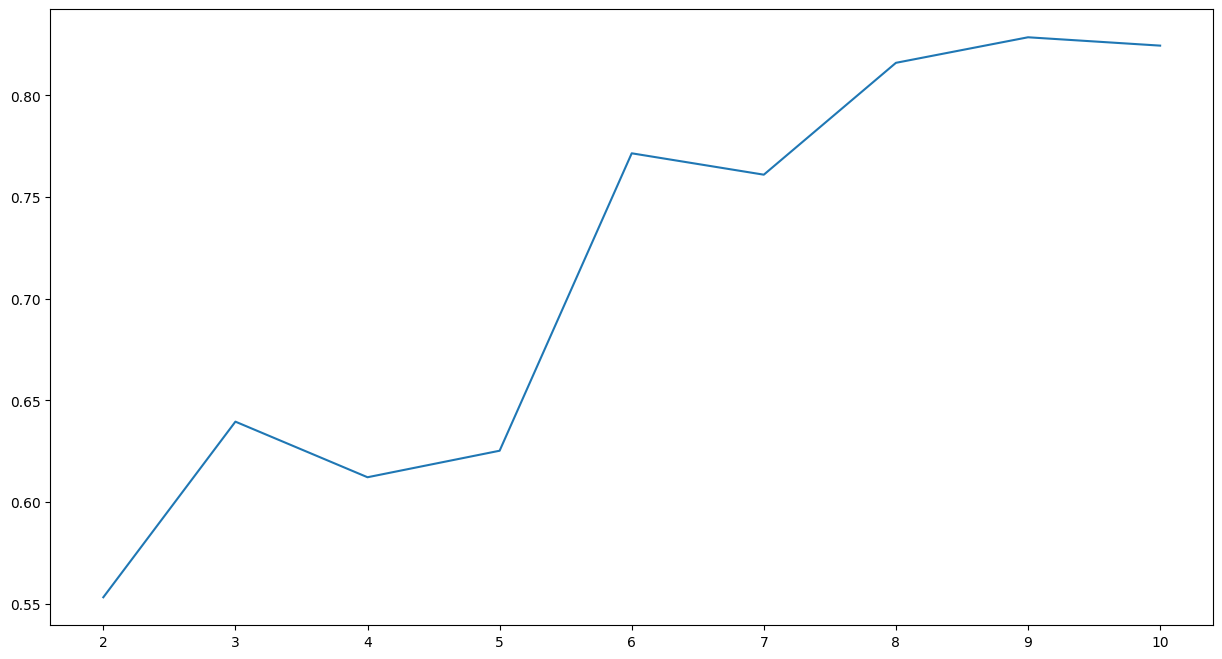

In [28]:
plt.figure(figsize=(15, 8))

plt.plot(np.arange(2, 11), silhouette_scores)

plt.show()

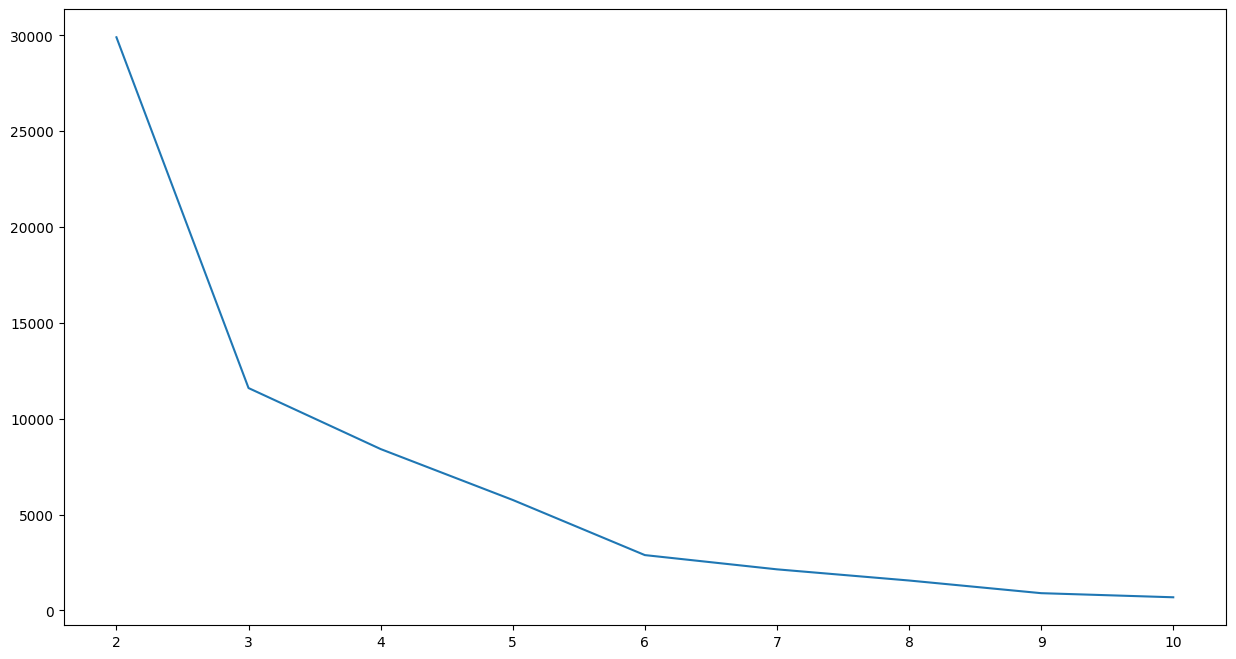

In [29]:
plt.figure(figsize=(15, 8))

plt.plot(np.arange(2, 11), inertia_scores)

plt.show()

In [30]:
kmeans = MiniBatchKMeans(n_clusters=6, batch_size=4_000)

labels = kmeans.fit_predict(patterns)

In [31]:
def get_closest_points_indices(data, k=3, n_closest=1, batch_size=100, n_init=10, random_state=None):

    # Mini Batch K-Means clustering
    kmeans = MiniBatchKMeans(n_clusters=k, batch_size=batch_size, n_init=n_init, random_state=random_state)
    labels = kmeans.fit_predict(data)

    # Initialize dictionary to store closest point indices for each cluster
    closest_points_indices = {cluster: [] for cluster in range(k)}

    # Find the N most close data points for each cluster
    for cluster in range(k):
        cluster_mask = (labels == cluster)
        cluster_data = data[cluster_mask]
        centroid = kmeans.cluster_centers_[cluster]
        distances = np.linalg.norm(cluster_data - centroid, axis=1)
        closest_point_indices = np.argsort(distances)[:n_closest]
        closest_point_global_indices = np.where(cluster_mask)[0][closest_point_indices]
        closest_points_indices[cluster] = closest_point_global_indices.tolist()

    return closest_points_indices

In [32]:
closest_points_indices = get_closest_points_indices(patterns, k=9, n_closest=10)

In [33]:
closest_points_indices[0]

[28015, 35267, 34980, 14932, 36867, 11568, 11056, 13355, 10620, 10673]

In [34]:
#Give examples of each cluster
behaviour_categories_examples = [[corpus[i] for i in closest_points_indices[j]] for j in range(9)]

Verify if the clustering give results similar to the ground truth of the genrated data.

In [35]:
ground_truth_labels = [np.ones(b[2])*i for i, b in enumerate(BEHAVIOURS_SPECIFY)]

ground_truth_labels = np.concatenate(ground_truth_labels)

In [36]:
ground_truth_labels[closest_points_indices[1]]

array([4., 4., 3., 3., 3., 3., 4., 3., 3., 3.])

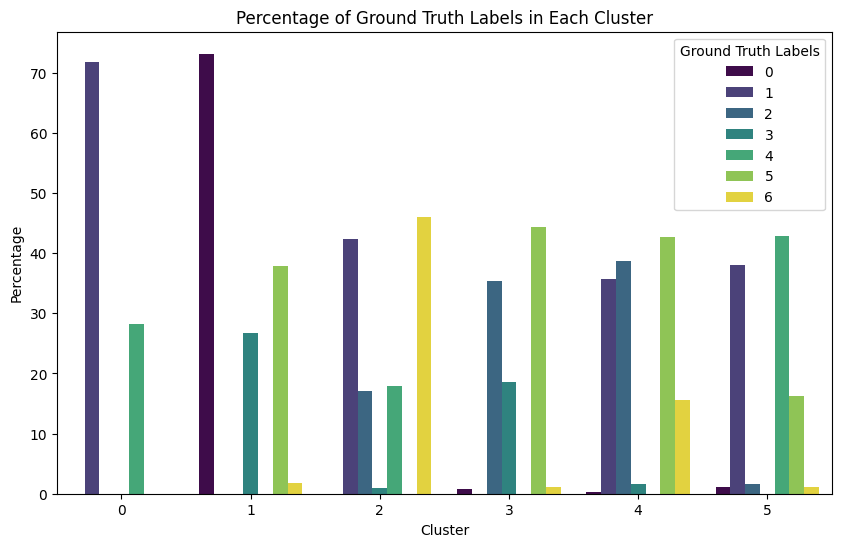

In [37]:
import seaborn as sns
from sklearn.metrics.cluster import contingency_matrix

def plot_cluster_barplot(cluster_labels, ground_truth_labels):

    contingency = contingency_matrix(ground_truth_labels, cluster_labels)


    percentages = (contingency.T / contingency.sum(axis=1)).T * 100

    x_values = np.arange(len(np.unique(cluster_labels)))

    percentages_flat = percentages.flatten()

    plt.figure(figsize=(10, 6))
    sns.barplot(x=np.repeat(x_values, len(np.unique(ground_truth_labels))),
                y=percentages_flat, hue=np.tile(np.unique(ground_truth_labels), len(x_values)),
                palette="viridis", dodge=True)

    # Add labels and legend
    plt.xlabel('Cluster')
    plt.ylabel('Percentage')
    plt.title('Percentage of Ground Truth Labels in Each Cluster')
    plt.legend(title='Ground Truth Labels', loc='upper right')

    # Show the plot
    plt.show()

# Example usage:
# Assuming you have cluster_labels and ground_truth_labels as lists
plot_cluster_barplot(labels, ground_truth_labels)